## Preparation

In [1]:
#!pip install spacy
#!pip install networkx
#!python -m spacy download en_core_web_sm # see https://spacy.io/usage/models
#!python -m spacy download en_core_web_trf
#!pip install pyvis
#!pip install python-louvain # community?

In [2]:
import spacy
import pandas as pd
import os
import codecs
import re 
import numpy as np
#from spacy import displacy
import networkx as nx
from pyvis.network import Network
import community.community_louvain as cl
import math
import ast
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load spacy English languague model
NER = spacy.load("en_core_web_sm")
#NER2 = spacy.load("en_core_web_trf")

#pd.set_option('display.max_rows', None)

In [4]:
# flatten a list of lists
def flatten(l):
    return [item for sublist in l for item in sublist]

# Function to filter out non-character entities
def filter_entity(ent_list, character_df):
    # check if entity is any part of a character name
    return flatten([character_df.character[
                np.any(
                    [np.array(character_df.character==ent), 
                     np.array(character_df.character_firstname==ent), 
                     np.array(character_df.character_secondname==ent)], 
                    axis=0).tolist()
            ] for ent in ent_list])
            #if ent in list(character_df.character)
            #or ent in list(character_df.character_firstname)
            #or ent in list(character_df.character_secondname)]

## Load character names

In [5]:
# Read characters
character_df = pd.read_csv("dataframes/characters.csv")

# take only characters from the current book
character_df = character_df.loc[character_df["book"] == "Gardens of the Moon"]

In [6]:
# remove titles only
title_list = [
    'Agent in Genabaris',
    'Assassin High House Shadow',
    'Black Moranth patrol leader',
    'Captain High House Light',
    'Captain (Itko Kan)',
    "Dassem Ultor's daughter",
    'Herald of High House Death',
    'Knight High House Dark',
    'Mason High House Death',
    'Soldier High House Death',
    'Throne (Unaligned)',
    'Virgin High House Death'
]
for title in title_list:
    character_df = character_df.drop(character_df[character_df.character==title].index)

In [43]:
# Remove brackets and stuff of names
character_df['character'] = character_df['character'].apply(lambda x: re.sub("\/|\(|\)", ' ', x)) #[\(].*?[\)]|
character_df['character'] = character_df['character'].apply(lambda x: re.sub("The |Corporal |Sergeant |Sergeant| Campaign|Empress |Emperor |Captain|Captain |Prince |Hound | Light Touch", "", x))

# split the names into firstname and lastname so we can find every mention of them
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 3)[0])
character_df['character_secondname'] = character_df['character'].apply(lambda x: x.split(' ', 3)[-1])
#character_df['character_thirdname'] = character_df['character'].apply(lambda x: x.split(' ', 3)[2])

character_df = character_df.reset_index(drop=True)

In [44]:
character_df

,book,character,character_firstname,character_secondname
0,Gardens of the Moon,A'Karonys,A'Karonys,A'Karonys
1,Gardens of the Moon,Anomander Rake,Anomander,Rake
2,Gardens of the Moon,Antsy,Antsy,Antsy
3,Gardens of the Moon,Apsalar,Apsalar,Apsalar
4,Gardens of the Moon,Aragan,Aragan,Aragan
...,...,...,...,...
142,Gardens of the Moon,Trotts,Trotts,Trotts
143,Gardens of the Moon,Turban Orr,Turban,Orr
144,Gardens of the Moon,Vildron,Vildron,Vildron
145,Gardens of the Moon,Vorcan,Vorcan,Vorcan


## Load books (first one here)

In [9]:
# Get all prefiltered book dataframes
all_books = [b for b in os.scandir('data') if b.name.endswith(".csv")]
book = all_books[0]
book_name = book.name.split(".")[0]
print(f"we read '{book_name}'")

# read book and make lists to lists (currently string after loading)
book = pd.read_csv(f"data/{book_name}.csv")
book.paragraphs = book.apply(lambda x: ast.literal_eval(x.paragraphs), axis=1)

we read '1 gardens_of_the_moon'


## Sentences with relevant entities

In [10]:
def run_model(paragraphs, index, df):
    print(f"chapter {(index+1):02}/{len(book)} running")
    for i,p in enumerate(paragraphs):        
        # run the language model on the paragraph
        paragraph_doc = NER(p)

        # get all the entities per sentence
        entity_df = []
        for sent in paragraph_doc.sents:
            entity_list = [ent.text for ent in sent.ents]
            entity_df.append({"chapter":index, "paragraph":i, "entities":entity_list})    

        # make it a dataframe
        entity_df = pd.DataFrame(entity_df)
        # remove all rows/sentences without any entities
        entity_df = entity_df[entity_df['entities'].map(len)>0] #entity_df.drop(entity_df[entity_df['entities'].map(len)==0].index, inplace=True)
        # filter out those entities that are characters
        entity_df['entities'] = entity_df['entities'].apply(lambda x: filter_entity(x, character_df))
        # now remove all rows/sentences without any characters
        entity_df = entity_df[entity_df['entities'].map(len)>0]
        
        # save those entities into a global dataframe
        df = pd.concat([df, entity_df])
        #return entity_df
    return df

In [11]:
entities_df = pd.read_csv(f"dataframes/entities_{book_name}.csv")
entities_df.entities = entities_df.apply(lambda x: ast.literal_eval(x.entities), axis=1)
entities_df

,chapter,paragraph,sentence,entities
0,0,0,32,[Dassem Ultor]
1,0,0,36,[Dassem Ultor]
2,0,0,88,"[Laseen, Laseen, Napan tutor]"
3,0,0,93,[Napan tutor]
4,0,0,100,[Napan tutor]
...,...,...,...,...
5235,25,2,33,[Crokus Younghand]
5236,25,2,35,[Kalam]
5237,25,2,36,[Crokus Younghand]
5238,25,2,40,[Circle Breaker]


## Building relationships

In [12]:
def metric(a,b,df):
    return df[a]+df[b] 

In [13]:
# paragraphs
unique_paragraphs = entities_df[["chapter","paragraph"]].drop_duplicates().reset_index(drop=True)
unique_paragraphs

,chapter,paragraph
0,0,0
1,1,0
2,1,1
3,1,2
4,1,3
...,...,...
218,24,4
219,24,5
220,25,0
221,25,1


In [14]:
exploded_df = entities_df.explode(column='entities',ignore_index=True)
exploded_df

,chapter,paragraph,sentence,entities
0,0,0,32,Dassem Ultor
1,0,0,36,Dassem Ultor
2,0,0,88,Laseen
3,0,0,88,Laseen
4,0,0,88,Napan tutor
...,...,...,...,...
5984,25,2,33,Crokus Younghand
5985,25,2,35,Kalam
5986,25,2,36,Crokus Younghand
5987,25,2,40,Circle Breaker


In [168]:
chapter_list = range(len(list(set(unique_paragraphs.chapter))))
#chapter_list = range(10)
chapter_list

range(0, 26)

In [176]:
df = exploded_df[exploded_df.chapter.isin(chapter_list)]
chars = sorted(df.entities.drop_duplicates())
df.set_index(["chapter","paragraph"]).loc[2,3]
df.set_index("entities").sort_index()
df = df.groupby(["chapter","paragraph","entities"], as_index=False).count()
df = df.rename(columns={"sentence": "occurences"})
df = df[df.occurences>0]
#df = df.set_index(["chapter","paragraph"]).sort_index()
#df = df.set_index(["entities","chapter","paragraph"]).sort_index()
df = df.reset_index(drop=True)

df["progress"] = 0
# enumerate the paragraphs over all chapters
for i in unique_paragraphs.index:
    df.progress = np.where((df[["chapter","paragraph"]]==unique_paragraphs.iloc[i]).all(axis=1), i, df.progress)
df

,chapter,paragraph,entities,occurences,progress
0,0,0,Dassem Ultor,2,0
1,0,0,Ganoes Stabro Paran,1,0
2,0,0,Laseen,2,0
3,0,0,Napan tutor,3,0
4,0,0,Surly,2,0
...,...,...,...,...,...
1206,25,2,Coll,1,222
1207,25,2,Crokus Younghand,7,222
1208,25,2,Eel,1,222
1209,25,2,Fiddler,1,222


In [260]:
occurence_df = df[df.chapter.isin(chapter_list)].groupby("entities", sort=False)["occurences"].count().to_frame().sort_values(by=["occurences", "entities"], ascending=[False,True])
occurence_df

,occurences
entities,
Ganoes Stabro Paran,64
Crokus Younghand,47
Kalam,42
Kruppe,42
Rallick Nom,42
...,...
Sandenay,1
Shan,1
Tarlow,1


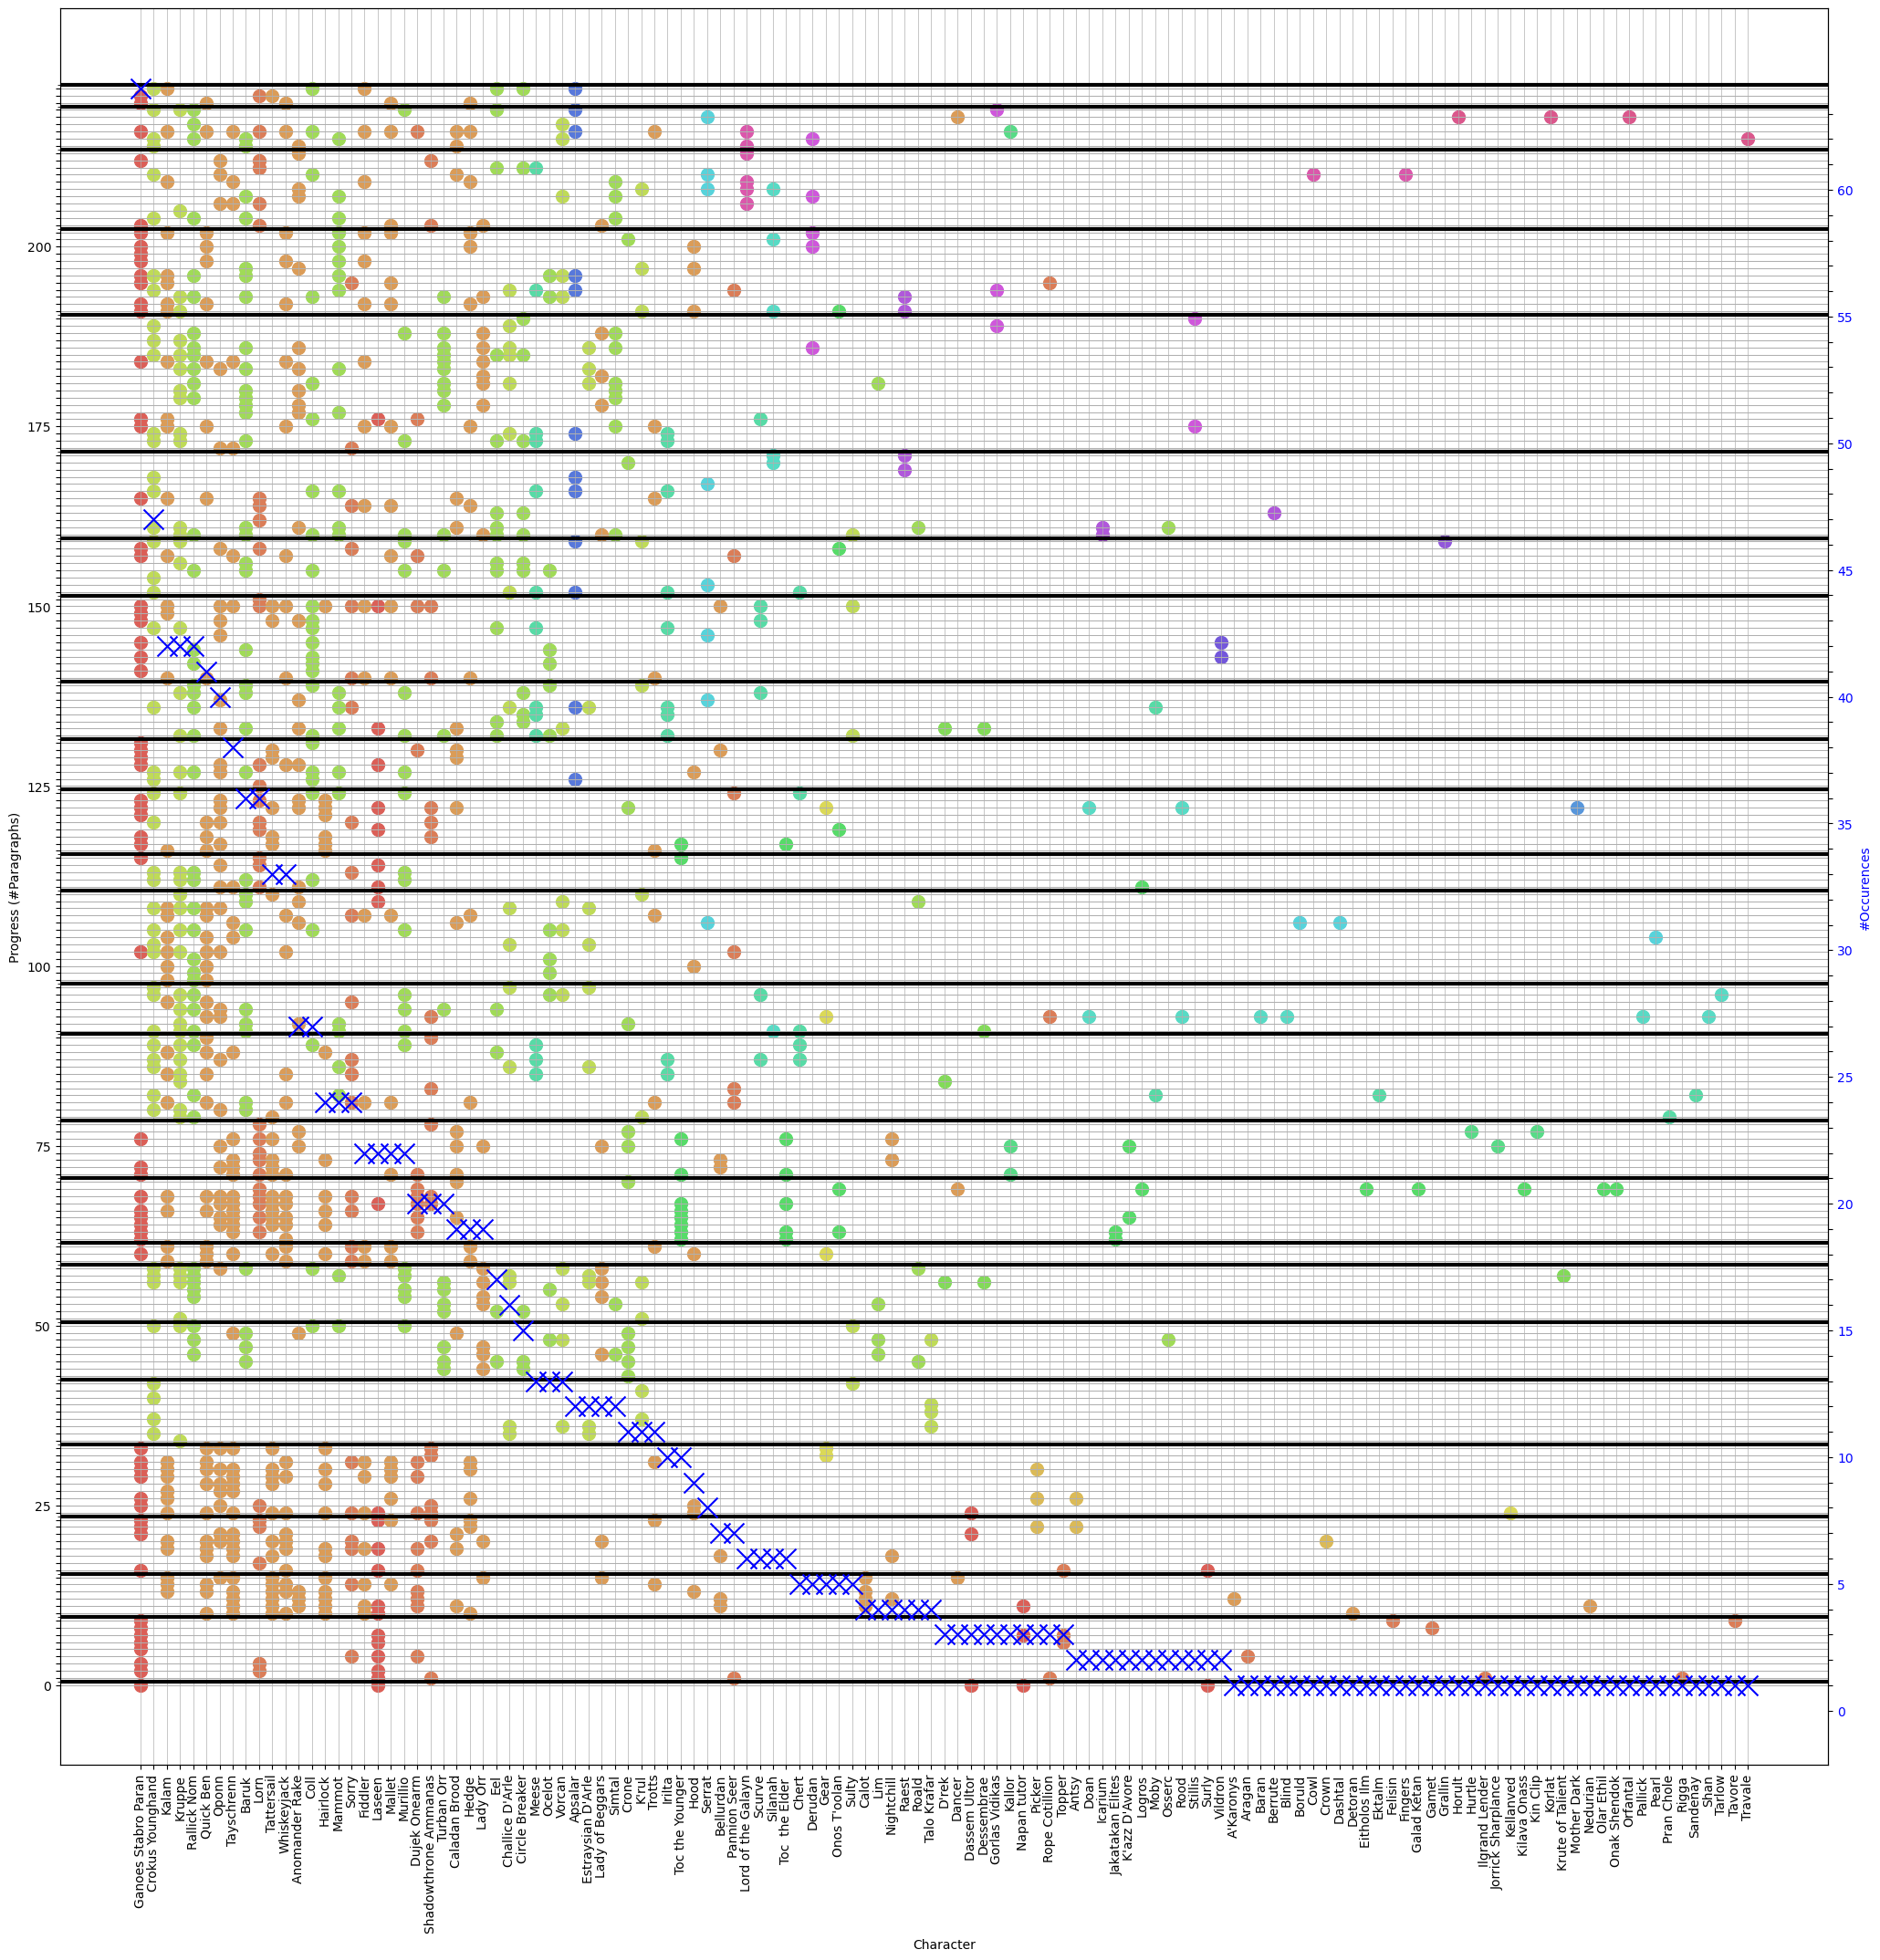

In [281]:
fig, ax = plt.subplots(figsize=(25,25))

colors = sns.color_palette("hls",len(chapter_list))
#colors = sns.color_palette("Spectral",len(chapter_list))
#random.shuffle(colors)

# first plot the characters on the x-axis sorted by their number of paragraph occurences
# later the grouped information is put onto this sorted axis!
# we can use a twin axis for this and display the number of occurences (axis) on the right side
ax_right = ax.twinx()
occurence_df.reset_index().plot(ax=ax_right, kind="scatter", x="entities", y="occurences", c="blue", marker="x", s=250)
ax_right.set_ylabel("#Occurences", c="blue")
occurence_ticks = range(max(occurence_df.occurences))
occurence_labels = [""] * len(occurence_ticks) # np.empty_like(paragraph_ticks)
occurence_labels[0::5] = range(0,len(occurence_labels),5)
ax_right.set_yticks(occurence_ticks, occurence_labels, c="blue")

# sorted by chapter and paragraph
# basically first occurence of a character
#grouped = df[df.chapter.isin(chapter_list)].groupby(["chapter","paragraph"])
#for key, group in grouped:
#    # colored by chapter
#    group.plot(ax=ax, kind='scatter', y='progress', x='entities', ylabel="Progress (#Paragraphs)", xlabel="Character", color=colors[key[0]], marker="s", s=100)

# characters (not sorted alphabetically)
grouped = df[df.chapter.isin(chapter_list)].groupby("entities", sort=False)
for key, group in grouped:
    #print(key)
    #print(group)
    # colored by their first chapter appearances
    # size by number of occurences (biased, think of Kruppe talking about himself in 3rd person...)
    group.plot(ax=ax, kind='scatter', y='progress', x='entities', ylabel="Progress (#Paragraphs)", xlabel="Character", 
               color=colors[group.chapter.values[0]], marker="o", s=100) #min(25*group.occurences.values[0],150))

# add gridlines for each new chapter
chapter_ticks = entities_df[["chapter","paragraph"]].drop_duplicates().groupby("chapter").count().cumsum()
chapter_ticks = np.array(list(chapter_ticks.paragraph.loc[chapter_list]))
paragraph_ticks = range(chapter_ticks[-1])
paragraph_labels = [""] * len(paragraph_ticks) # np.empty_like(paragraph_ticks)
paragraph_labels[0::25] = range(0,len(paragraph_ticks),25)

ax.set_yticks(chapter_ticks-0.5, minor=True)
ax.yaxis.grid(True, which='minor', lw=3, c="black")
ax.set_yticks(paragraph_ticks, paragraph_labels, minor=False)
ax.yaxis.grid(True, which="major", lw=0.75)
ax.xaxis.grid(True, lw=0.5)

ax.tick_params(axis='x', rotation=90)
#ax.tick_params(axis='y', rotation=90)
#ax_right.tick_params(axis='y', rotation=90)

#plt.show()
plt.savefig("visualization/occurences.png", dpi=150)

In [157]:
# store relationships here
relationships = []

for i in range(len(unique_paragraphs)):
    # get the rows that are the same paragraphs
    paragraph_df = entities_df[(entities_df[["chapter","paragraph"]]==unique_paragraphs.iloc[i]).all(axis=1)]

    # build the character list that appear in one paragraph
    char_list = sum((paragraph_df.entities), [])
    char_unique = sorted(list(set(char_list)))
    char_histogram = pd.DataFrame(char_list,columns=["entity"]).groupby('entity')['entity'].count()
    
    # Remove duplicated characters that are next to each other
    #char_list.sort()
    #char_unique = [char_list[i] for i in range(len(char_list)) if (i==0) or char_list[i] != char_list[i-1]]
    
    # get source-target relationships
    #print(char_histogram)
    if len(char_unique) > 1:
        for i,a in enumerate(char_unique[:-1]):
            j = 1
            while j < len(char_unique)-i:
                b = char_unique[i+j]
                relationships.append({"source": a, "target": b, "value": metric(a,b,char_histogram)})
                j = j+1

In [95]:
relationship_df = pd.DataFrame(relationships).groupby(["source","target"], sort=True, as_index=False).sum()
relationship_df

,source,target,value
0,A'Karonys,Anomander Rake,5
1,A'Karonys,Bellurdan,10
2,A'Karonys,Calot,15
3,A'Karonys,Dujek Onearm,6
4,A'Karonys,Hairlock,12
...,...,...,...
1360,Topper,Whiskeyjack,9
1361,Travale,Vorcan,16
1362,Trotts,Whiskeyjack,67
1363,Turban Orr,Vorcan,13


In [20]:
# save this relational dataframe as csv
relationship_df.to_csv(f"dataframes/relationships_{book_name}.csv", index=False)

### The most important characters in The Malazan Book of the Fallen

### Evolution of characters' importance